In [1]:
import pandas as pd
import numpy as np

import dask
import dask.dataframe as dd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, HTML, clear_output
import time

def draw_progress_bar(iteration, total, prefix='', suffix='', length=50):
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = '#' * filled_length + '-' * (length - filled_length)
    progress_str = f'{prefix} [{bar}] {percent}% {suffix}'
    return progress_str

In [3]:
image_server_demand_data = pd.read_csv('image_server_demand_with_time.csv',index_col='time_to',parse_dates=True)

In [4]:
image_server_demand_data.shape[0]

19889

In [5]:
columns_to_drop = ['Hour']
image_server_demand_data = image_server_demand_data.drop(columns=columns_to_drop)

In [6]:
image_server_demand_data['data_demand_20secs'].iloc[2]

3013475

In [7]:
image_server_demand_data = image_server_demand_data.sort_values(by='time_to')

In [8]:
image_server_demand_data.head(5)

,data_demand_20secs
time_to,
2019-01-22 04:00:23,708933
2019-01-22 04:00:43,674238
2019-01-22 04:01:03,355476
2019-01-22 04:01:24,635822
2019-01-22 04:01:46,136022


In [9]:
image_server_demand_data.describe()

,data_demand_20secs
count,1.988900e+04
mean,2.874295e+06
std,1.847198e+06
min,1.890000e+02
25%,1.317265e+06
50%,2.888426e+06
75%,4.103807e+06
max,1.107373e+07


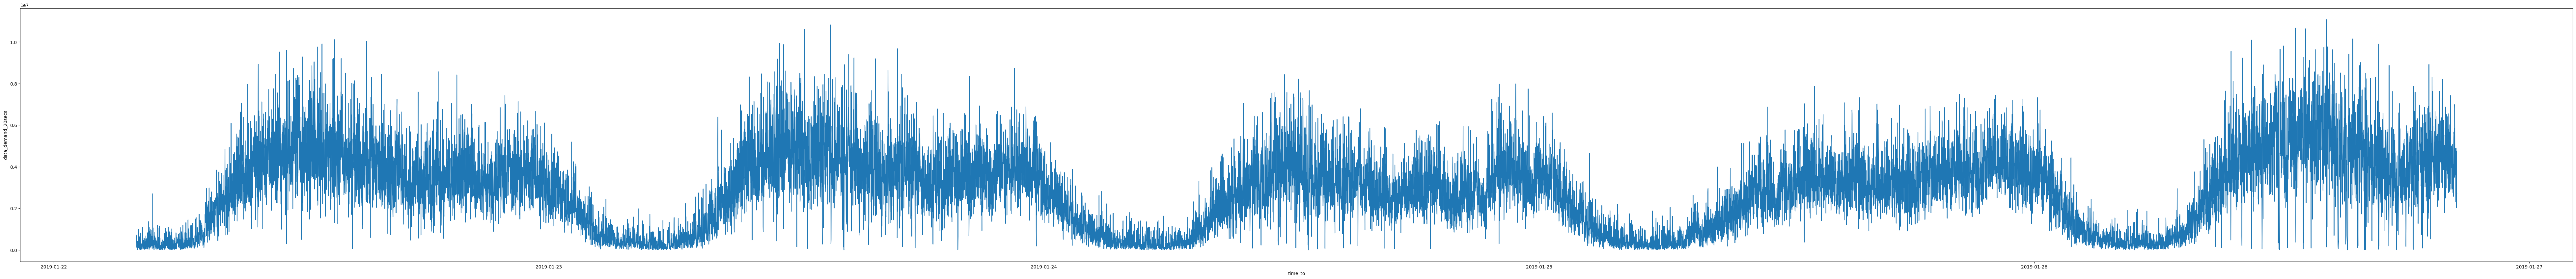

In [10]:
plt.figure(figsize=(100, 10))
sns.lineplot(x='time_to', y='data_demand_20secs', data=image_server_demand_data)
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

# X_train, X_test = train_test_split(image_server_demand_data, test_size=0.3, random_state=42)

X_train = image_server_demand_data.iloc[:12000]
X_test = image_server_demand_data.iloc[12000:]

In [12]:
X_train = X_train.sort_values(by='time_to')
X_train.head()

,data_demand_20secs
time_to,
2019-01-22 04:00:23,708933
2019-01-22 04:00:43,674238
2019-01-22 04:01:03,355476
2019-01-22 04:01:24,635822
2019-01-22 04:01:46,136022


In [13]:
X_train.shape[0]

12000

In [14]:
X_test.shape[0]

7889

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [16]:
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

In [37]:
min_values = scaler.data_min_
max_values = scaler.data_max_
print(min_values)
print(max_values)

[211.]
[10824431.]


In [17]:
scaled_train

array([[0.06547557],
       [0.06227026],
       [0.0328213 ],
       ...,
       [0.44704551],
       [0.42323548],
       [0.43172145]])

In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator

2024-01-19 14:13:30.506138: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# define generator
n_input = 6
# Other values - 30, 90, 180, 540
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [20]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.06547557 0.06227026 0.0328213  0.05872118 0.01254695 0.01148064]
Predict this y: 
 [[0.00935144]]


In [21]:
X.shape

(1, 6, 1)

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [23]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# fit model
model.fit(generator,epochs=20)

Epoch 1/20
11994/11994 [==============================] - 60s 5ms/step - loss: 0.0118
Epoch 2/20
11994/11994 [==============================] - 65s 5ms/step - loss: 0.0113
Epoch 3/20
11994/11994 [==============================] - 67s 6ms/step - loss: 0.0112
Epoch 4/20
11994/11994 [==============================] - 69s 6ms/step - loss: 0.0112
Epoch 5/20
11994/11994 [==============================] - 61s 5ms/step - loss: 0.0112
Epoch 6/20
11994/11994 [==============================] - 75s 6ms/step - loss: 0.0112
Epoch 7/20
11994/11994 [==============================] - 65s 5ms/step - loss: 0.0111
Epoch 8/20
11994/11994 [==============================] - 69s 6ms/step - loss: 0.0111
Epoch 9/20
11994/11994 [==============================] - 67s 6ms/step - loss: 0.0111
Epoch 10/20
11994/11994 [==============================] - 77s 6ms/step - loss: 0.0111
Epoch 11/20
11994/11994 [==============================] - 71s 6ms/step - loss: 0.0111
Epoch 12/20
11994/11994 [===========================

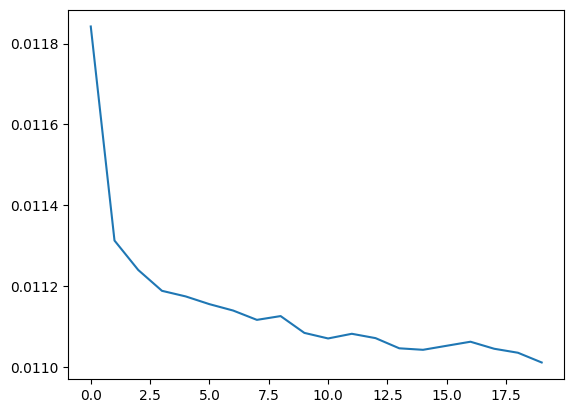

In [26]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [27]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]

current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(X_test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:], scaled_test[i:i+1].reshape(1, 1, -1) ,axis=1)


1/1 [==============================] - 0s 25ms/step


In [35]:
print(first_eval_batch)

[[0.47311428]
 [0.46080189]
 [0.29194067]
 [0.44704551]
 [0.42323548]
 [0.43172145]]


In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

In [29]:
X_test['Predictions'] = true_predictions

/var/folders/l2/wrgblk9d1q7cdfmxbw_xvqw80000gn/T/ipykernel_12470/290687461.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Predictions'] = true_predictions


<Axes: xlabel='time_to'>

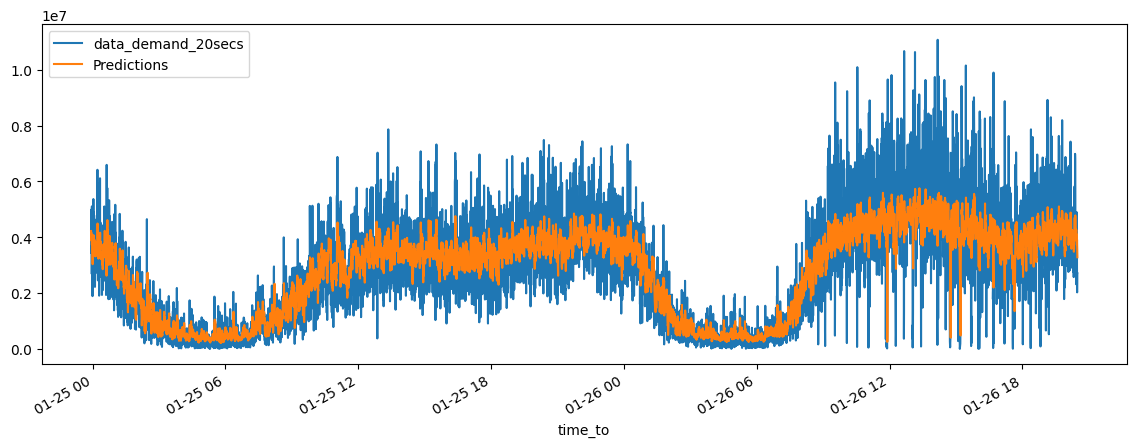

In [30]:
X_test.plot(figsize=(14,5))

In [31]:
import pickle

In [32]:
with open('LSTM_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [33]:
with open('InverseTransform.pkl', 'wb') as model_file:
    pickle.dump(scaler, model_file)